# **5.5 Reshaping transforms**

This lesson covers moving data between rows and columns. This is often called pivoting, a name from Pito Salas’s work that combines data summarization and shape transforms. Examples will be worked in three packages: data.table, cdata (which only
reshapes data, and does not summarize data), and tidyr. Base R does have notations
for these transforms (such as stack() and unstack()), but the package versions are
significantly better tools

**5.5.1 Moving data from wide to tall form**

We will show how to move data records where all measurements are in single rows to a
new record set where data is in multiple rows. We call this moving from a wide form to
a thin or tall form.

**DATA EXAMPLE**

Let’s work with measurements of vehicle drivers/passengers injured or killed, by
month. The data includes additional information about fuel price and whether seatbelts are required by law.

Relevant variables for this example:
* date—Year and month of measurement (numeric representation)
* DriversKilled—Car drivers killed
* front—Front seat passengers killed or seriously injured
* rear—Rear seat passengers killed or seriously injured
* law—Whether or not seatbelt law was in effect (0/1)


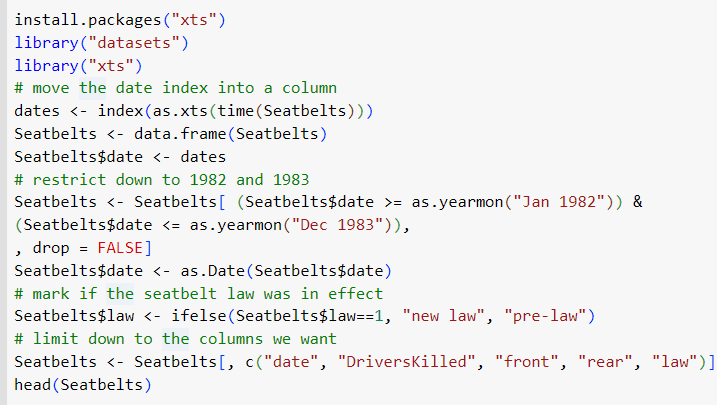

In [2]:
install.packages("xts")
library("datasets")
library("xts")
# move the date index into a column
dates <- index(as.xts (time (Seatbelts)))
Seatbelts <- data.frame(Seatbelts)
Seatbelts$date <- dates
# restrict down to 1982 and 1983
Seatbelts <- Seatbelts[ (Seatbelts$date >= as.yearmon("Jan 1982")) &
(Seatbelts$date <= as.yearmon("Dec 1983")),
, drop = FALSE]
Seatbelts$date <- as.Date(Seatbelts$date)
# mark if the seatbelt law was in effect
Seatbelts$law <- ifelse(Seatbelts$law==1, "new law", "pre-law")
# limit down to the columns we want
Seatbelts <- Seatbelts[, c("date", "DriversKilled", "front", "rear", "law") ]
head(Seatbelts)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘zoo’


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




,date,DriversKilled,front,rear,law
,<date>,<dbl>,<dbl>,<dbl>,<chr>
157,1982-01-01,115,595,238,pre-law
158,1982-02-01,104,673,285,pre-law
159,1982-03-01,131,660,324,pre-law
160,1982-04-01,108,676,346,pre-law
161,1982-05-01,103,755,410,pre-law
162,1982-06-01,115,815,411,pre-law


To get our data into a presentable format, we have performed transforms described in
earlier sections of this chapter: selecting rows, selecting columns, adding new derived
columns, and so on. The data now has one row per date (we think of the date as the
row-key) and contains information such as how many people were killed in each of
three seating positions (driver, front, rear) and if the new seatbelt law was in effect.
We want to see if the new seatbelt law saves lives. Notice that we are missing a key bit
of information: a normalizing factor such as number of cars owned per date, driving
population size by date, or total miles driven per date (risks make more sense as rates
than as absolute counts). This is an example of true data science being an iterative
process: we are going to do the best job we can with the data at hand, but in a real
project, we would also go back to sources and partners to try to get the critical missing
data (or at least an estimate or proxy for the missing data).

Let’s plot the data conditioned on the law:

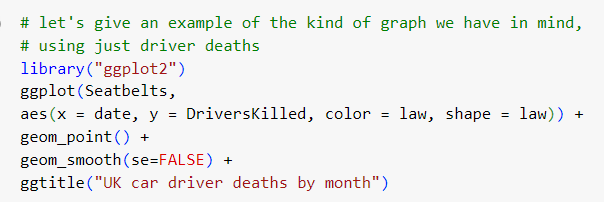

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


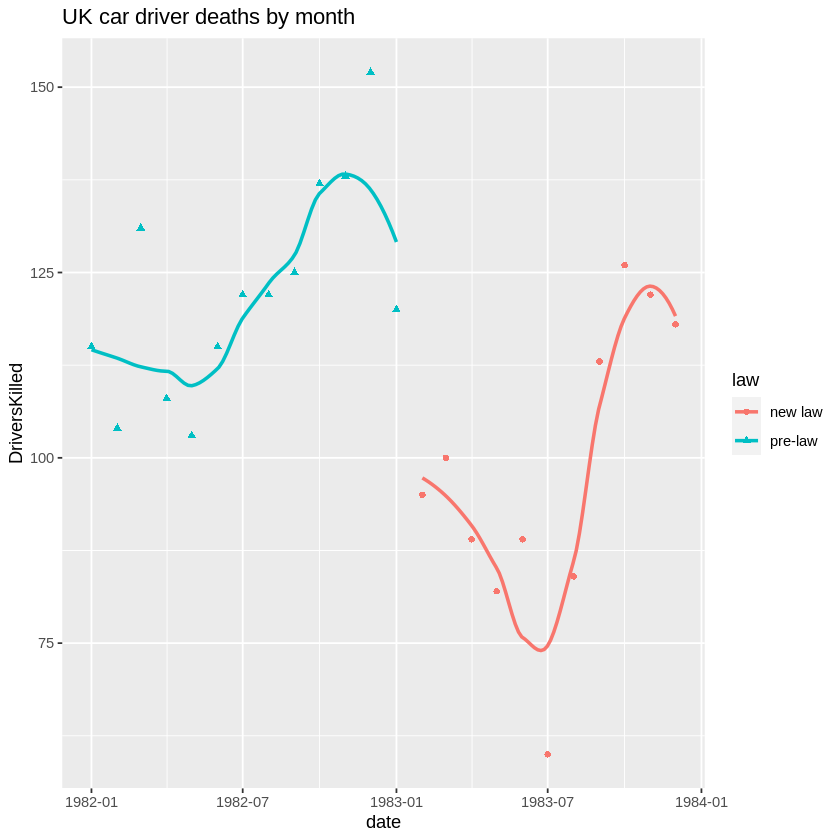

In [7]:
# let's give an example of the kind of graph we have in mind,
# using just driver deaths
install.packages("ggplot2")
library("ggplot2")
ggplot(Seatbelts,
aes(x = date, y = DriversKilled, color = law, shape = law)) +
geom_point() +
geom_smooth(se=FALSE) +
ggtitle("UK car driver deaths by month")

From the chart, it looks like the introduction of the seatbelt law produced a drop in
deaths that is non-trivial when compared to the normal variation in deaths. It also
looks like the effect may have reverted quickly.

Suppose our follow-up question is to break down this data further to seating position (as types of seatbelts differ quite a bit by seating position).

To make such a plot with ggplot2, we need to move the data from all facts being in
each row to having one row per seating position. This is an example of moving from a wide or denormalized format, the natural format for machine learning tasks, to a tall
or multiline record format.

**PROBLEM**

Plot deaths conditioned on date and seating position, using ggplot2. ggplot2
requires the data to be in a long, rather than wide, format. So we will concentrate on
how to perform this transform. We call this sort of transform moving data from row oriented records to blocks of rows,

**Solution 1: data.table::melt.data.table()**

We can solve this with data.table::melt.data.table(). Specify the columns of the
original table that the values are to be taken from with the measure.vars argument.
Specify the pair of columns the information is to be written into in the transformed
table with the arguments variable.name (the new key column) and value.name (the
new value column)

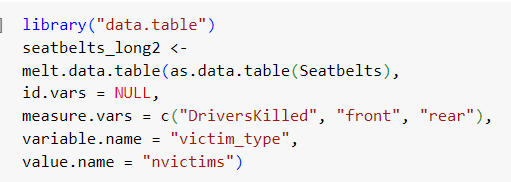

In [9]:
library("data.table")
seatbelts_long2 <-
melt.data.table(as.data.table(Seatbelts),
id.vars = NULL,
measure.vars = c("DriversKilled", "front", "rear"),
variable.name = "victim_type",
value.name = "nvictims")


Attaching package: ‘data.table’


The following objects are masked from ‘package:xts’:

    first, last




These new graphs do show us something more: the law had essentially no effect on
people in the rear seats. This could be perhaps because the law didn't cover these
seats, perhaps enforcing rear seat compliance was difficult, or perhaps rear-seat seatbelts were lap belts (instead of three-point restraints) and were not effective. The
strongest benefit seems to be to front-seat passengers, and that is not too unusual, as
they tend to have high-quality seatbelts and are not sitting in front of the steering column (a primary source of fatal injuries).

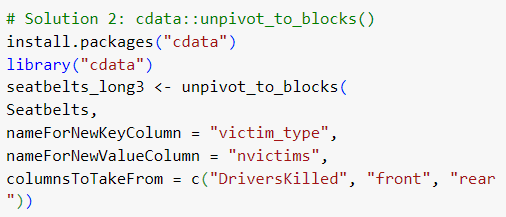

In [13]:
# Solution 2: data::unpivot to blocks)
install.packages("cdata")
library("cdata")
seatbelts_long3 <- unpivot_to_blocks (
Seatbelts,
nameForNewKeyColumn = "victim_type",
nameForNewValueColumn = "nvictims",
columnsToTakeFrom = c("DriversKilled", "front", "rear"))

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



cdata has simple methods to specify the coordinated conversions of many columns at
once. A good introduction can be found at http://www.win-vector.com/blog/2018/
10/faceted-graphs-with-cdata-and-ggplot2/.
We encourage you to try all three solutions and convince yourself they produce the
equivalent results. We prefer the cdata solution, but it is new and not as well known as
the data.table or tidyr solutions.

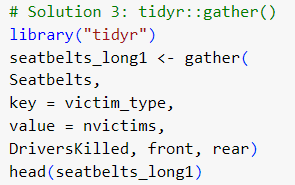

In [16]:
# Solution 3: tidyr: :gather ()
install.packages("tidyr")
library("tidyr")
seatbelts_long1 <- gather (
Seatbelts,
key = victim_type,
value = nvictims,
DriversKilled, front, rear)
head(seatbelts_long1)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘tidyr’


The following objects are masked from ‘package:wrapr’:

    pack, unpack




,date,law,victim_type,nvictims
,<date>,<chr>,<chr>,<dbl>
1,1982-01-01,pre-law,DriversKilled,115
2,1982-02-01,pre-law,DriversKilled,104
3,1982-03-01,pre-law,DriversKilled,131
4,1982-04-01,pre-law,DriversKilled,108
5,1982-05-01,pre-law,DriversKilled,103
6,1982-06-01,pre-law,DriversKilled,115


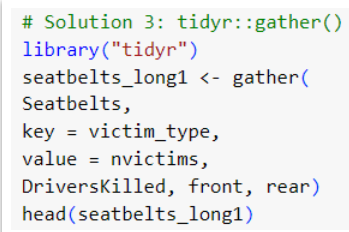

In [18]:
# Solution 3: tidyr: :gather ()
library("tidyr")
seatbelts_long1 <- gather(
Seatbelts,
key = victim_type,
value = nvictims,
DriversKilled, front, rear)
head(seatbelts_long1)

,date,law,victim_type,nvictims
,<date>,<chr>,<chr>,<dbl>
1,1982-01-01,pre-law,DriversKilled,115
2,1982-02-01,pre-law,DriversKilled,104
3,1982-03-01,pre-law,DriversKilled,131
4,1982-04-01,pre-law,DriversKilled,108
5,1982-05-01,pre-law,DriversKilled,103
6,1982-06-01,pre-law,DriversKilled,115


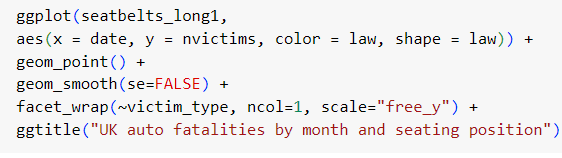

`geom_smooth()` using method = 'loess' and formula = 'y ~ x'


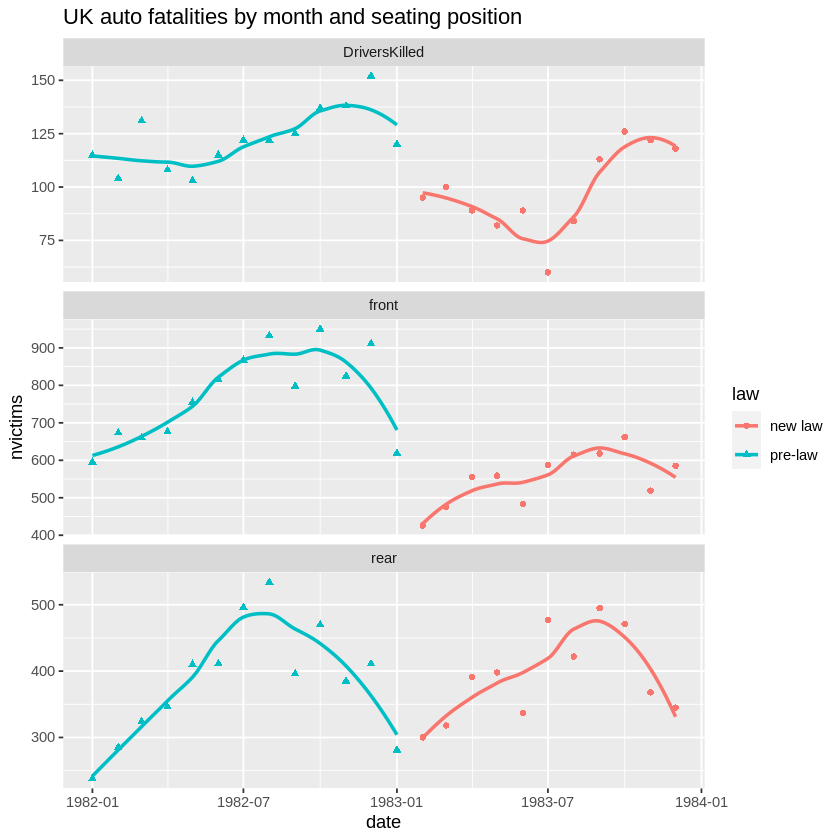

In [21]:
ggplot(seatbelts_long1,
aes(x = date, y = nvictims, color = law, shape = law)) +
geom_point() +
geom_smooth(se=FALSE) +
facet_wrap(~victim_type, ncol=1, scale="free_y") +
ggtitle("UK auto fatalities by month and seating position")

And we now have the passenger death data faceted by seating position

**5.5.2 Moving data from tall to wide form**

We have been given data in a log style, where each detail of a measurement is written
in a separate row. Colloquially, we call this a tall or thin data form (formally, it is
related to information storage ideas such as RDF triples). The operation of moving to

a wide form is very much like what Microsoft Excel users call pivoting, except aggregations (sums, averages, counts) are not strictly part of moving from tall to wide form
(we suggest aggregating first before transforming). Also, moving from tall to wide
form is, of course, the inverse of the moving from wide to tall form conversion we discussed earlier.

**THE DATA**

For our example, we have taken the ChickWeight data from R’s datasets package.
Please try these commands and take extra steps to examine the
data (using commands such as View(), head(), summary() and so on):

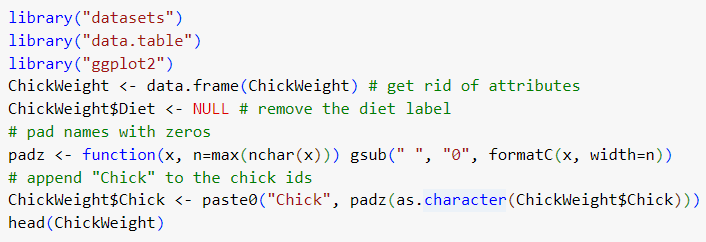

In [22]:
library("datasets")
library("data.table")
library("ggplot2")
ChickWeight <- data.frame(ChickWeight) # get rid of attributes
ChickWeight$Diet <- NULL # remove the diet label
# pad names with zeros
padz <- function(x, n=max(nchar (x))) gsub (" ", "g", formatC(x, width=n))
# append "Chick" to the chick ids
ChickWeight$Chick <- paste0("Chick", padz (as.character (ChickWeight$Chick)))
head(ChickWeight)

,weight,Time,Chick
,<dbl>,<dbl>,<chr>
1,42,0,Chickg1
2,51,2,Chickg1
3,59,4,Chickg1
4,64,6,Chickg1
5,76,8,Chickg1
6,93,10,Chickg1


This data is organized so each row is a single fact (weight) about a given chick at a
given time. The is a very easy format to produce and transmit, which is why it is popular in scientific settings. To perform interesting work or learn from the data, we need
to bring the data into a wider structure. For our problem, we would like all the weight
facts about a chick to be in a single row, with time as the new column name.
Before doing that, let’s use some of our earlier lessons to get a look at the data. We
can aggregate the data to move from information about individuals to overall trends.

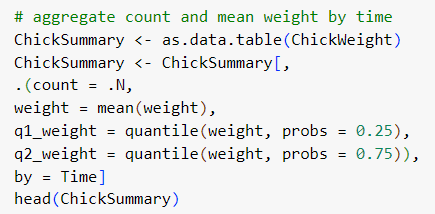

In [25]:
# aggregate count and mean weight by time
ChickSummary <- as.data.table(ChickWeight)
ChickSummary <- ChickSummary[,
.(count = .N,
weight = mean(weight),
q1_weight = quantile(weight, probs = 0.25),
q2_weight = quantile(weight, probs = 0.75)),
by = Time]
head(ChickSummary)

Time,count,weight,q1_weight,q2_weight
<dbl>,<int>,<dbl>,<dbl>,<dbl>
0,50,41.06000,41,42
2,50,49.22000,48,51
4,49,59.95918,57,63
6,49,74.30612,68,80
8,49,91.24490,83,102
10,49,107.83673,93,124


In ChickSummary the only key is Time (specified by the data.tableby argument) and
we can now see how many chicks are surviving at a given time and the distribution of
surviving chick weights at a given time.
We can present this table graphically. To use ggplot2 to do this, we need to move
the summarized data to a tall form (as ggplot2 prefers to work with tall data). We use
cdata::unpivot_to_blocks:

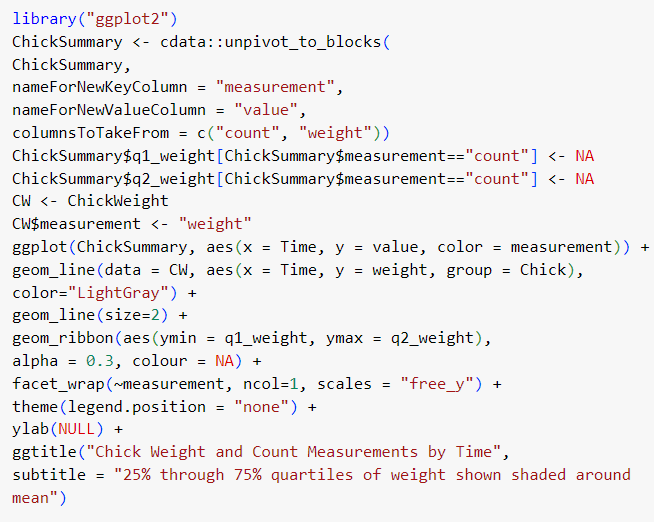

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in max(ids, na.rm = TRUE):
“no non-missing arguments to max; returning -Inf”


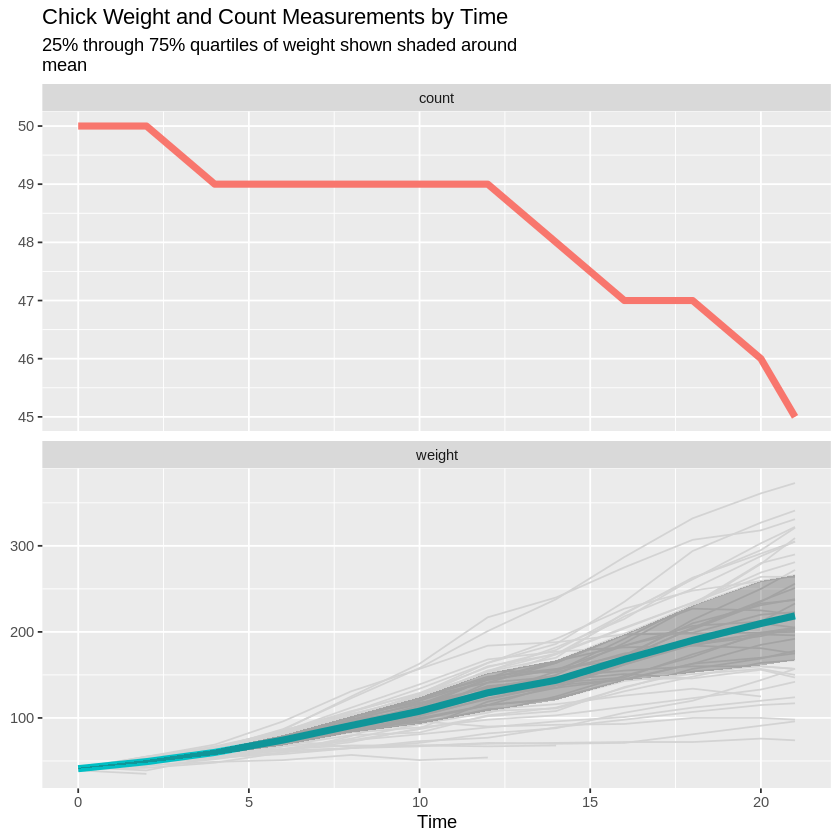

In [27]:
library("ggplot2")
ChickSummary <- cdata::unpivot_to_blocks(
ChickSummary,
nameForNewKeyColumn = "measurement",
nameForNewValueColumn = "value",
columnsToTakeFrom = c("count", "weight"))
ChickSummary$q1_weight[ChickSummary$measurement=="count"] <- NA
ChickSummary$q2_weight[ChickSummary$measurement=="count"] <- NA
CW <- ChickWeight
CW$measurement <- "weight"
ggplot(ChickSummary, aes(x = Time, y = value, color = measurement)) +
geom_line(data = CW, aes(x = Time, y = weight, group = Chick),
color="LightGray") +
geom_line(size=2) +
geom_ribbon(aes (ymin = q1_weight, ymax = q2_weight),
alpha = 0.3, colour = NA) +
facet_wrap(~measurement, ncol=1, scales = "free_y") +
theme(legend.position = "none") +
ylab(NULL) +
ggtitle("Chick Weight and Count Measurements by Time",
subtitle = "25% through 75% quartiles of weight shown shaded around
mean")

This gives the chick weights organized by time and chick, as shown in figure 5.20.
Here we have plotted the total count of surviving chicks as a function of time, plus
the weight trajectory of each individual check, and the summary statistics (mean
weight, and 25% through 75% quartiles of weight).

**PROBLEM**

We can now return to the example task of this section: putting all the information
about each chick into a single row.

**Solution 1: data.table::dcast.data.table()**

To move data to a wide form using dcast.data.table(), we specify the rows and columns of a result matrix using a formula with the ~notation. We then say how to populate the cells of this matrix with the value.var argument. In our case, to get a data
frame with a row per chick, a column per time, and weight in the cells, we use the following step:

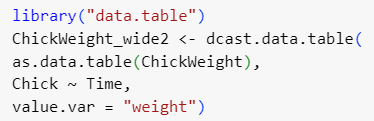

In [28]:
library("data.table")
ChickWeight_wide2 <- dcast.data.table(
as.data.table(ChickWeight),
Chick ~ Time,
value.var = "weight")

This table is a matrix where the row is identified by the chick, and the column is time.
The cells contain the weight for the given chick and time (and NA if the chick did not
survive to a given time). Notice that this format is much easier to read and may be
required for reporting.
data.table’s implementation of dcast also allows more-powerful transforms, such
as casting to multiple variables and aggregations at the same time.

**Solution 2: cdata::pivot_to_rowrecs()**

cdata::pivot_to_rowrecs() describes the intended table by row-keys, column to
take new column keys from, and column to take values from :

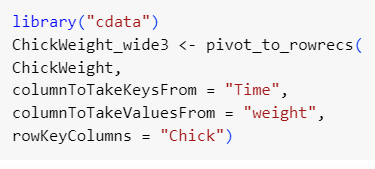

In [36]:
install.packages("cdata")
library("cdata")
ChickWeight_wide3 <- pivot_to_rowrecs(
ChickWeight,
columnToTakeKeysFrom= "Time",
columnToTakeValuesFrom ="weight",
rowKeyColumns = "Chick")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



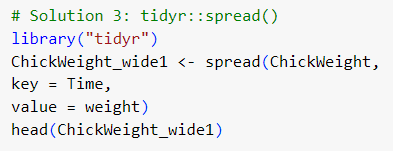

In [38]:
# Solution 3: tidyr: :spread ()
library("tidyr")
ChickWeight_wide1 <- spread(ChickWeight,
key = Time,
value = weight)
head(ChickWeight_wide1)

,Chick,0,2,4,6,8,10,12,14,16,18,20,21
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Chick10,41,44,52,63,74,81,89,96,101,112,120,124
2,Chick11,43,51,63,84,112,139,168,177,182,184,181,175
3,Chick12,41,49,56,62,72,88,119,135,162,185,195,205
4,Chick13,41,48,53,60,65,67,71,70,71,81,91,96
5,Chick14,41,49,62,79,101,128,164,192,227,248,259,266
6,Chick15,41,49,56,64,68,68,67,68,NA,NA,NA,NA
